# Simulating Language second assignment 

## Question1

In very broad and few words, ideas related to language faculty assume language as evolved under natural selection for a specific function, this specificity imposes strong contraints such as a domain-specific cognitive mechanisms and brain implementation. Because this evolution is mainly genetical, they also suppose that the way in which language is socially transmitted across generations doesn't influence language this biological linguistic trait or bias. 

Computer simulations have provided us with the possibility of exploring large-scale phenomena, impossible otherwise. Previously, ideas on this topic were dependant merely on the scholars approach and eventual related findings; on the other hand, simulations can provide scientific data. 

From this computer-based modeling framework, probably the most important idea until now is the notion of language structure as a dynamic learning-culture-evolution product, rather than a pure genetically determined language-organ. 
In particular, using a bayesian, iterated-learning based model showed that regularity across generations in a population of agents depends more on the cultural bottleneck (number of productions passed from one generations to the next) and that just a slight genetic bias is required (bayesian prior). This evidence supports the idea of cultural amplification of domain-general small cognitive biases and poses serious doubts on the language faculty notion. 

This perspective of language as a highly interactive derived object derived from cultural, learning and evolutive systems, gives a more feasible explanation on language structure by which:

- each individual learns a language as phenomena from the world, abstracting its regularities and then produces language from what he's learnt 

- cultural bottleeck defines what language features are the most useful and productive and language becomes more useful and learnable for humans to learn it

- across generations humans become better learners as long language-learning represents a valuable adaptive feature


An important difference by which we could understand the idea of culture is that while most patterns emerge from regular-natural phenomena, language only occurs in the world by/in humans. In bayesian terms, evidence for hypothesis-elaboration can only proceed from observation/interaction within the socio-cultural group, this difference is trivialized by non-cultural models of language, as they are implicitely conceiving human interaction as equivalent to any other natural phenomena. 

On these lines, we can say that human cognition has a profound domain-general bias towards systematicity, that is reflected in how we tend to generate general patterns by which the world becomes simpler. In the particular case of language, underpined by this learning mechanism, patterns are retrieved from the actions of the other members of the population. Hence, the language productions of the learners, based on their previous learning, will be the data from which future individuals will learn.


In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from math import log, log1p, exp
from scipy.misc import logsumexp

import sys
#from tqdm import tqdm

/anaconda3/envs/py2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
learning = 'sample'     # The type of learning ('map' or 'sample')
bias = log(0.6)         # The preference for regular languages
variables = 2           # The number of different variables in the language
variants = 2            # The number of different variants each variable can take
noise = log(0.05)       # The probability of producing the wrong variant
population_size = 1000  # Size of population
teachers = 'single'     # Either 'single' or 'multiple'
method = 'chain'        # Either 'chain' or 'replacement'

In [3]:
def log_subtract(x,y):
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                        #equivalent to dividing in the normal domain
    return normedlogs
 
def log_roulette_wheel(normedlogs):
    r = log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

def wta(items):
    maxweight = max(items)
    candidates = []
    for i in range(len(items)):
        if items[i] == maxweight:
            candidates.append(i)
    return random.choice(candidates)

In [32]:
def produce(language):
    variable = random.randrange(len(language))
    correct_variant = language[variable]
    if log(random.random()) > noise:
        return [variable, correct_variant]
    else:
        possible_noise_variants = range(variants)
        possible_noise_variants.remove(correct_variant)
        noisy_variant = random.choice(possible_noise_variants)
        return [variable, noisy_variant]

def regular(language):
    regular = True
    first_variant = language[0]
    for variant in language:
        if variant != first_variant:
            regular = False
    return regular

def proportion_regular_language(population):
    regular_count = 0
    for agent in population:
        if regular(agent):
            regular_count += 1
    return regular_count / float(len(population))

def logprior(language):
    if regular(language):
        number_of_regular_languages = variants
        return bias - log(number_of_regular_languages) 
    else:
        number_of_irregular_languages = pow(variants, variables) - variants
        return log_subtract(0, bias) - log(number_of_irregular_languages)
    
def loglikelihood(data, language):
    loglikelihoods = []
    logp_correct = log_subtract(0, noise) 
    logp_incorrect = noise - log(variants - 1) 
    for utterance in data:
        variable = utterance[0]
        variant = utterance[1]
        if variant == language[variable]:
            loglikelihoods.append(logp_correct)
        else:
            loglikelihoods.append(logp_incorrect)
    return sum(loglikelihoods)

def all_languages(n):
    if n == 0:
        return [[]]
    else:
        result = []
        smaller_langs = all_languages(n - 1)
        for l in smaller_langs:
            for v in range(variants):
                result.append(l + [v])
        return result

def learn(data):
    list_of_all_languages = all_languages(variables)
    list_of_posteriors = []
    for language in list_of_all_languages:
        this_language_posterior = loglikelihood(data, language) + logprior(language)
        list_of_posteriors.append(this_language_posterior)
    if learning == 'map':
        map_language_index = wta(list_of_posteriors)
        map_language = list_of_all_languages[map_language_index]
        return map_language
    if learning == 'sample':
        normalized_posteriors = normalize_logprobs(list_of_posteriors)
        sampled_language_index = log_roulette_wheel(normalized_posteriors)
        sampled_language = list_of_all_languages[sampled_language_index]
        return sampled_language
    
def pop_learn(adult_population,bottleneck,number_of_learners):
    new_population = []
    for n in range(number_of_learners):
        if teachers == 'single':
            potential_teachers = [random.choice(adult_population)]
        if teachers == 'multiple':
            potential_teachers = adult_population
        data = []
        for n in range(bottleneck):
            teacher = random.choice(potential_teachers)
            utterance = produce(teacher)
            data.append(utterance)
        learner_grammar = learn(data)
        new_population.append(learner_grammar)
    return new_population

def initial_population(n):
    population = []
    possible_languages = all_languages(variables)
    for agent in range(n):
        language=random.choice(possible_languages)
        population.append(language)
    return population

def iterate(generations, bottleneck, report_every):
    population = initial_population(population_size)
    accumulator=[proportion_regular_language(population)]
    for g in range(1, generations + 1):
        
        # shows current simulation state without filling the screen
        # printing takes time, can be commented/deleted if in a hurry 
        sys.stdout.write("\rlearning={0}, method={1}, teachers={2}, \
bottleneck={3}, bias={4}, generations={5} out of {6}".format(\
learning, method, teachers, bott, bias_val, g, gens))
        sys.stdout.flush()
        
        if method == 'chain': 
            population = pop_learn(population, bottleneck, population_size)
        if method == 'replacement': 
            population = population[1:]
            new_agent = pop_learn(population, bottleneck, 1)[0]
            population.append(new_agent)
        if (g % report_every == 0):
            #print '.',
            accumulator.append(proportion_regular_language(population))
    return population, accumulator

# Question2

For comparing different results that eventually could support or not the idea of linguistic universals as a reflection of the language faculty we will run multiples simulations and plot their results. We will use **plot_data** function to plot the results with different values for alpha (bias towards language), for different bottleneck values. 

In [19]:
''''
customized helper function to plot
input: data, subplot_reference
optional input: fontsize, title, label for legend
'''
def plot_data(data, ax, fontsize=10, title=None, label=None):
    ax.plot(data, label=label)
    ax.locator_params(nbins=3)
    ax.set_xlabel("generations (x"+str(report)+")", fontsize=fontsize)
    ax.set_ylabel("regular proportion", fontsize=fontsize)
    ax.set_ylim([0,1])
    ax.set_xlim([0,len(data)-1])
    ax.set_title("bottleneck = "+str(title), fontsize=fontsize)
    ax.legend(bbox_to_anchor=(0.12, 1.20, 1.7, .102), ncol=4, loc=3,\
              mode="expand", borderaxespad=0)    
    plt.tight_layout()                                        

For making the experiment more complete, we will run simulations for the same bottleneck/bias values using different learning, method and teachers parameters options.

In [26]:
learn_options = "sample", "map"
method_options = "chain", "replacement"
teachers_options = "single", "multiple"

generations_vals = [100, 1000]
bottleneck_vals = [3, 5, 7, 10]
bias_vals = [0.5, 0.6, 0.75, 0.9]

report = 10

The **compare()** function below is a simple iterative function that calls the **iterate(generations,bottleneck, report_every)** function introduced in the last lab. Then it saves the data for the 4 bias values for the every bottleneck value, plot this data, and allocate it as a subplot of a more general plot of all the bottleneck values given the same generations input.

In [29]:
def compare():
    simulations = []
    regular_sims = []
    
    # iteratively define parameters
    global learning
    for learning in learn_options:
        global method
        for method in method_options:
            global teachers
            for teachers in teachers_options:
                
                global gens
                for gens in generations_vals:                    

                    bottleneck_results = []
                    global bott
                    for bott in bottleneck_vals:
                    
                        bias_results = []
                        global bias
                        global bias_val
                        for bias_val in bias_vals:
                            bias = log(bias_val)

                            # store selected parameters
                            parameters = (learning, method, teachers,\
                                          bott, gens, bias_val)
                            
                            # run the simulation
                            x = iterate(gens, bott, report)                            

                            # store the results
                            simulations.append((x[0], x[1], parameters))                            
                            if sum(x[1][-10:])/10 >= 0.9:
                                regular_sims.append((x[1], parameters))
                            # bias results 
                            bias_results.append(x[1])
                        # bottleneck(bias) results
                        bottleneck_results.append(bias_results)
                        
                    # plot
                    # generations(bottleneck(bias))
                    plt.close('all')
                    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(\
                                                    nrows=2, ncols=2)                    
                    for br, bl in zip(bottleneck_results, bias_vals):
                        plot_data(br[0], ax1, title=bottleneck_vals[0],\
                                  label="bias="+str(bl))
                        plot_data(br[1], ax2, title=bottleneck_vals[1])
                        plot_data(br[2], ax3, title=bottleneck_vals[2])
                        plot_data(br[3], ax4, title=bottleneck_vals[3])
                    sys.stdout.write("\rlearning={0}, method={1},\ 
 teachers={2}, generations={3}".format(learning, method, teachers, gens))
                    plt.show()
      
    return simulations, regular_sims

learning=sample, method=chain, teachers=single, bottleneck=10, bias=0.9, generations=100 out of 100

/anaconda3/envs/py2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


learning=sample, method=chain, teachers=single, generations=100

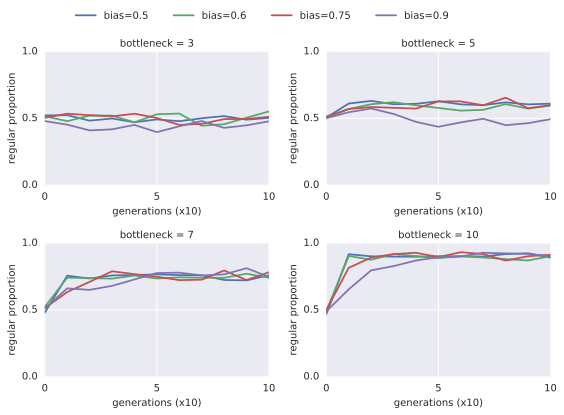

learning=sample, method=chain, teachers=single, generations=1000

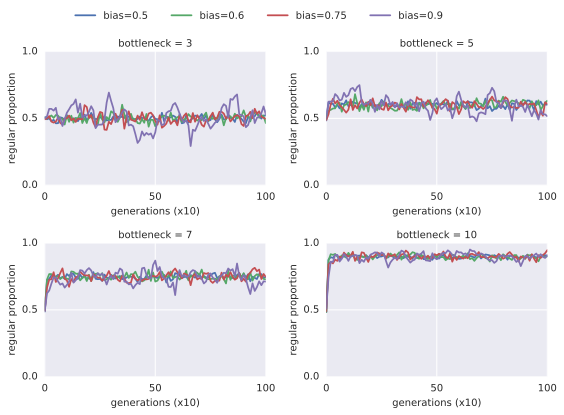

learning=sample, method=chain, teachers=multiple, generations=100

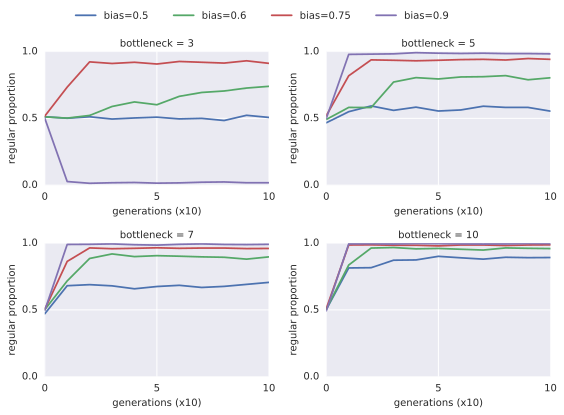

learning=sample, method=chain, teachers=multiple, generations=1000

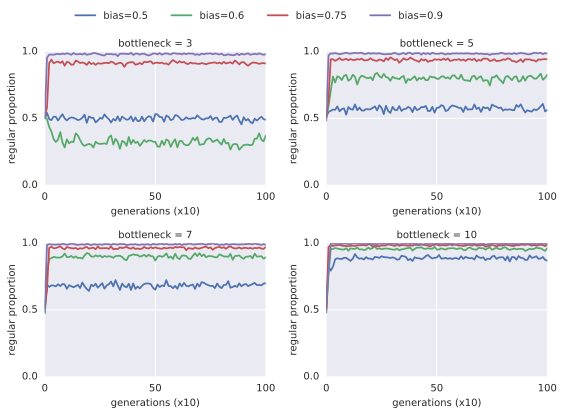

learning=sample, method=replacement, teachers=single, generations=100

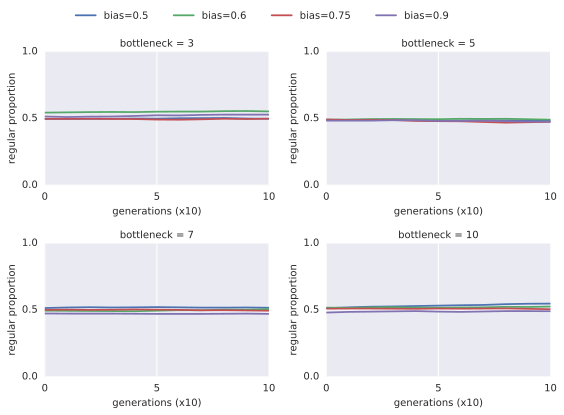

learning=sample, method=replacement, teachers=single, generations=1000

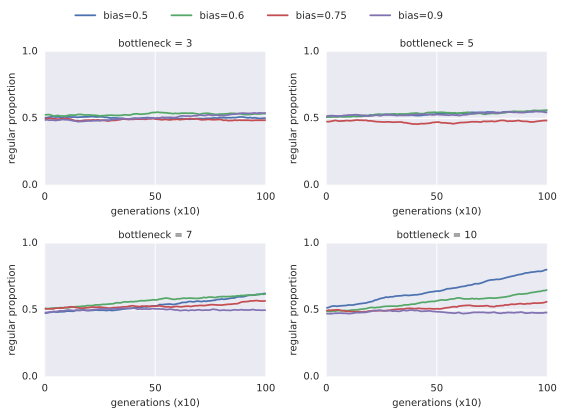

learning=sample, method=replacement, teachers=multiple, generations=100

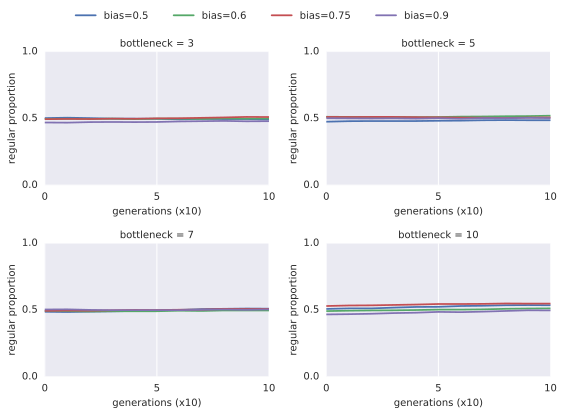

learning=sample, method=replacement, teachers=multiple, generations=1000

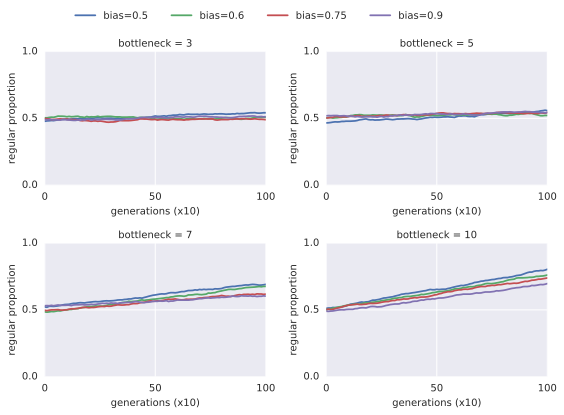

learning=map, method=chain, teachers=single, generations=100

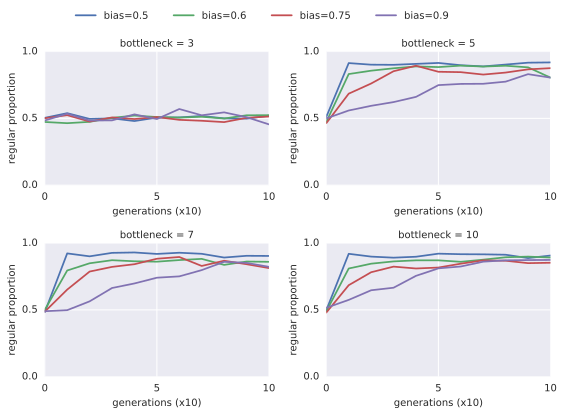

learning=map, method=chain, teachers=single, generations=1000

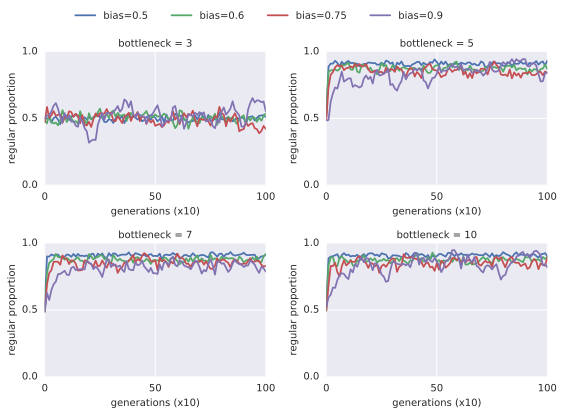

learning=map, method=chain, teachers=multiple, generations=100

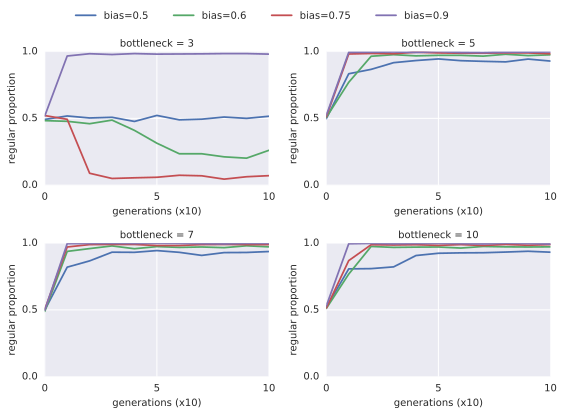

learning=map, method=chain, teachers=multiple, generations=1000

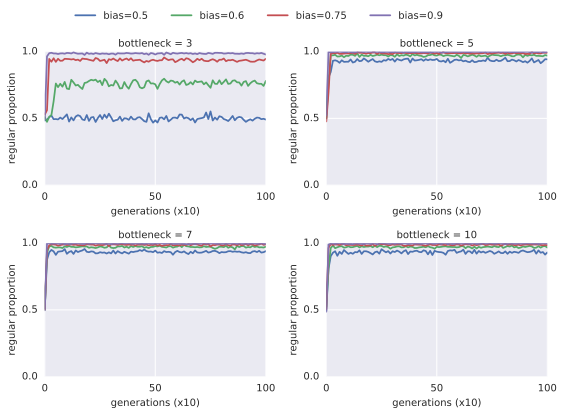

learning=map, method=replacement, teachers=single, generations=100

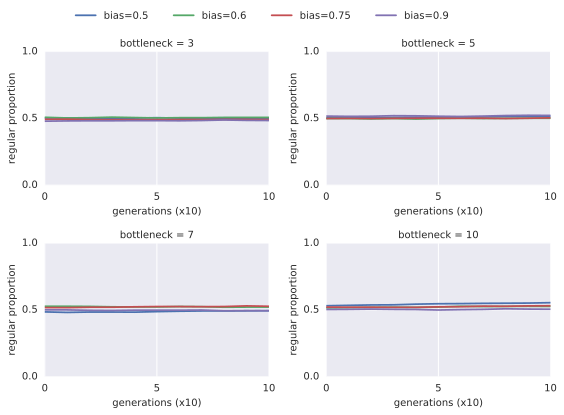

learning=map, method=replacement, teachers=single, generations=1000

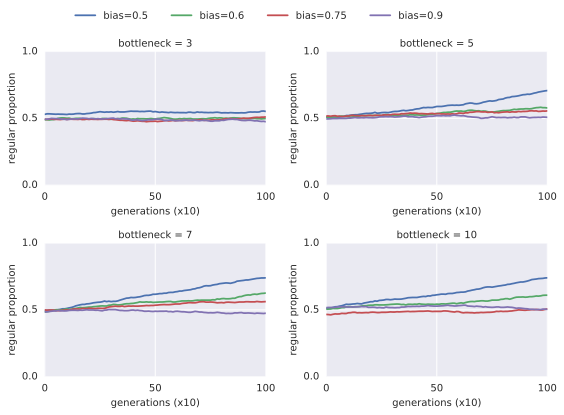

learning=map, method=replacement, teachers=multiple, generations=100

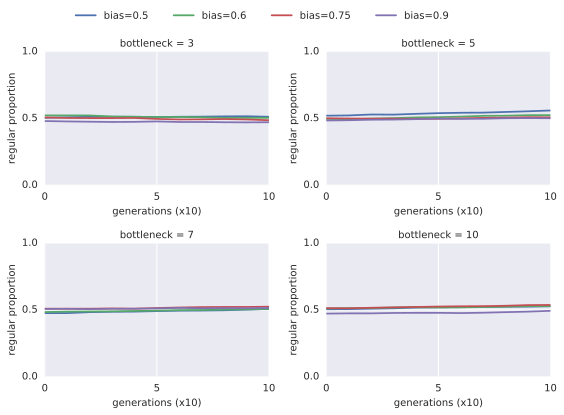

learning=map, method=replacement, teachers=multiple, generations=1000

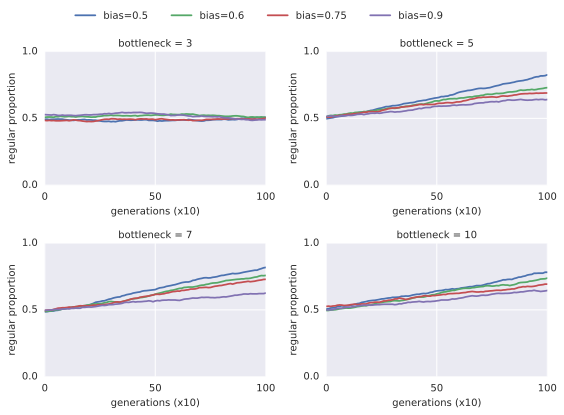

In [30]:
sims, reg_sims = compare()

- Method: 
Independently of other parameters the **replacement** method yields similar results, because populations are totally replaced every time there's no proper learning and we just see a very slow progress by fitness. For 100 generations there's no notorious regularization, even if for 1000 generations regularity is not so high, but it is predictable that probably they will keep regularizing until 1.0 with enough amount of time. 


- Learning: 
Within the **chain** method simulations, we can see that MAP simulations raise regularity with lower bottleneck values, this makes sense because if agents select the best option from the distribution they will need a smaller range to transmit the correct/regular variants from one generation to another. **Sample** need to have high bottleneck and/or bias values to acchieve regularity. 


- Teachers: 
**Multiple** teachers yield more distributed results, while curves based on **single** are similar between different bottleneck/bias values. This is interesting because show us that tha fact of learning from multiple teachers make the learning process of the agents more susceptible to the influence of these parameters. This could be investigated more in the future. 


- Consistency across generations: 
Results for 100 and 1000 generations match almost always, with the only exception being learning=sample_teachers=single_method=chain_bottleneck=3, in which because of the sampling method, high biases will quickly tend to converge to the extreme values. 


- Bias influence: 
The experiment results confirm the previous findings of the article, the value of the bias (from 0.5 to 0.9) doesn't affect significatively the long-time results how the proportion of regular speakers develope across generations. Being the only exception the above commented. 


- Bottleneck influence:
This is the most influent parameter of the set, in almost all the subexperiments result, the bottleneck clearly influences the procces of regularization of language. For more feasible parameters, going from 3 to 5 can make the difference, in others, just when bottleneck=10 they can increase regularization. Given that what is transmitted from one point in time to other is represented by the cultural bottleneck, these results supports as well the idea of cultural core importance in the evolution of language structure. 


### Conclusions

The preference for MAP and sampling could be associated to genetic factors, something closer to the language faculty perspective; however, this trait will be general, it has been found also in vision cardinal preference. 
In general though, these results show that the cultural process is fundamental to amplify/convert this weak biases into language, and universals will be consequence of similar needs more than hardwire.